In [1]:
# importing important required libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython.display as display
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# dataset directory 

content = sorted(list(os.listdir('/kaggle/input/coco-wikiart-nst-dataset-512-100000/content')))
style = sorted(list(os.listdir('/kaggle/input/coco-wikiart-nst-dataset-512-100000/style')))

content_dir = '/kaggle/input/coco-wikiart-nst-dataset-512-100000/content/'
style_dir = '/kaggle/input/coco-wikiart-nst-dataset-512-100000/style/'

# image transformation and prepocessing step 

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 256
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

## dataset preperation 

In [6]:
import tensorflow_hub as hub
from tqdm import tqdm
import tensorflow as tf

content_images = []  # stores content images
style_images = []     # stores style images
labels = []            # stores the generated stylized images for corrosponding images

# importing pretrained model from tensorflow hub 

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

for i in tqdm(range(600)):  # choosed 600 images out of 50k to check whether this approach works or not
    content_image = load_img(content_dir + content[i])
    style_image = load_img(style_dir + style[i])
    
    stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
    
    content_images.append(content_image)
    style_images.append(style_image)
    labels.append(stylized_image)

100%|██████████| 600/600 [00:21<00:00, 28.11it/s]


# build generator 

In [8]:
# architecture of generator which has a downsample and upsample part, based on Unet architecture

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [9]:
down_model = downsample(3, 4)
down_result = down_model(style_images[0], 0)
print (down_result.shape)

(1, 128, 128, 3)


In [10]:
# upsample part of generator 

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [12]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

# checking whether we are getting the same output shape as of input shape or not input shape (226,226,3)

(1, 256, 256, 3)


In [13]:
# finally the combination of downsample and upsampele merged architecture of generator

def Generator():
    
# in this part i took the both images as input and then added the fetures of both the images,
# then passed those features into the next conv layer 

  input_1 = tf.keras.layers.Input(shape=[256, 256, 3])
  input_2 = tf.keras.layers.Input(shape=[256, 256, 3])
  
  inputs = tf.keras.layers.add([input_1,input_2])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='relu')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=[input_1,input_2], outputs=x)

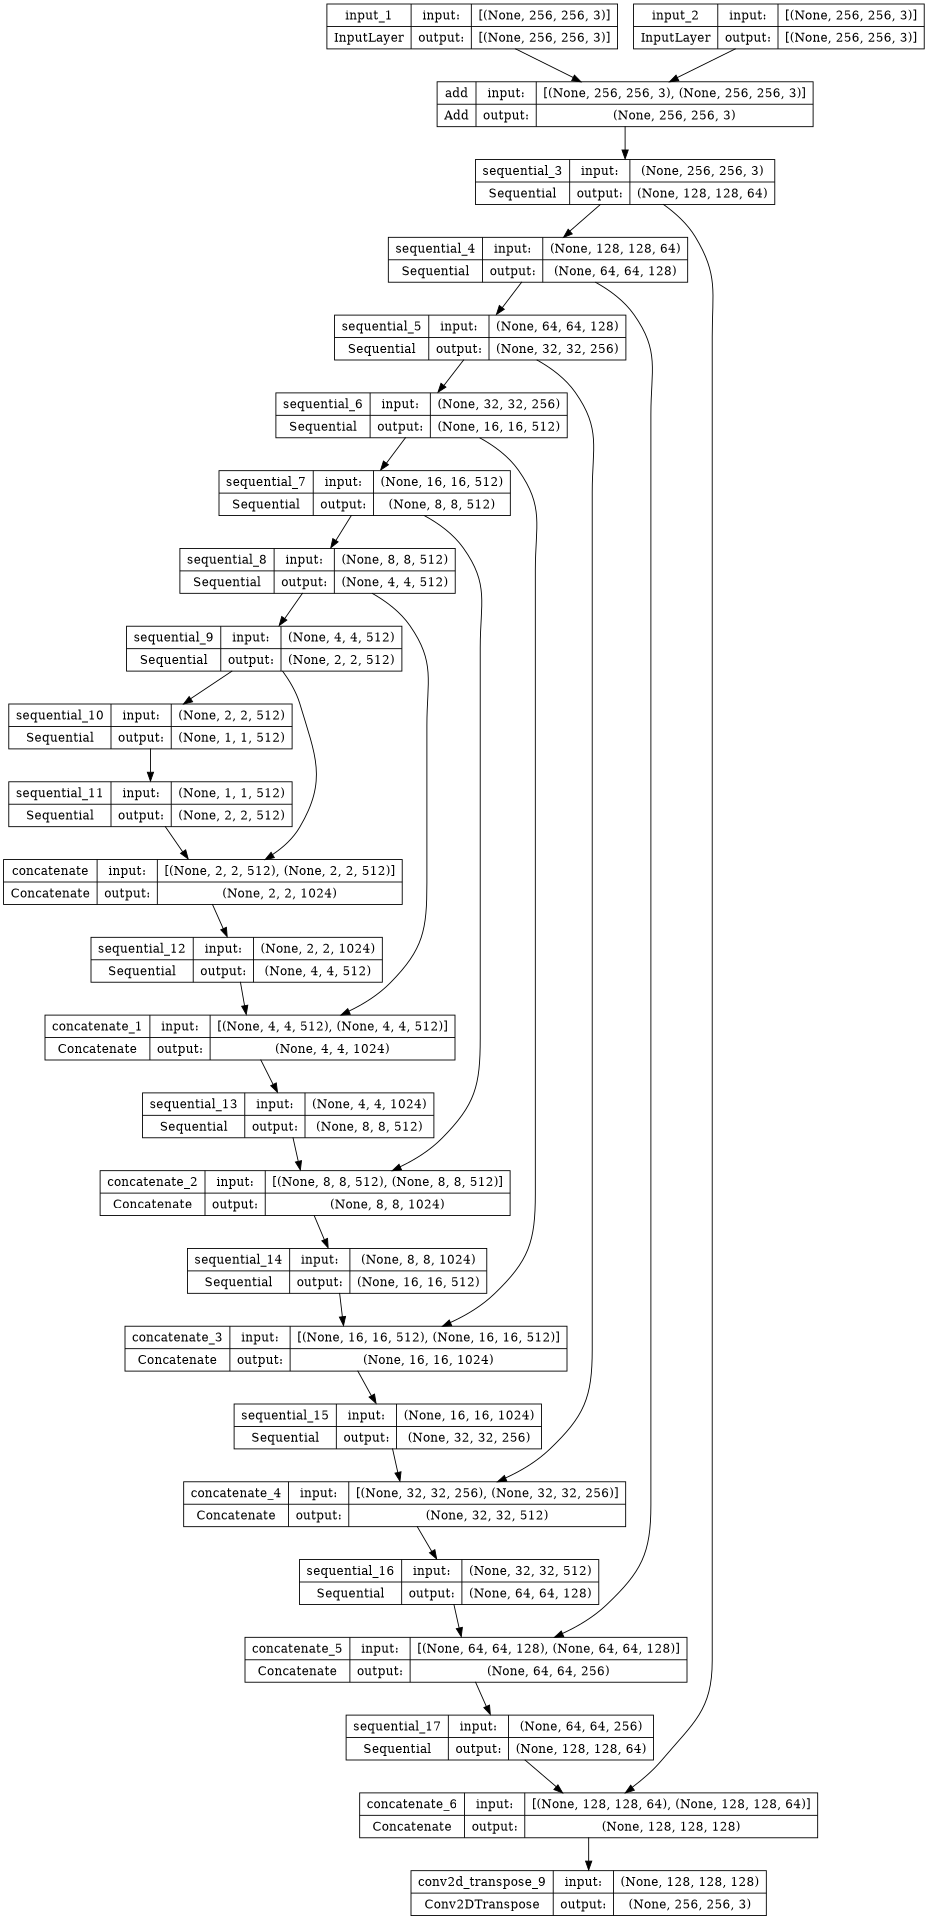

In [14]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)  # generator architecture design

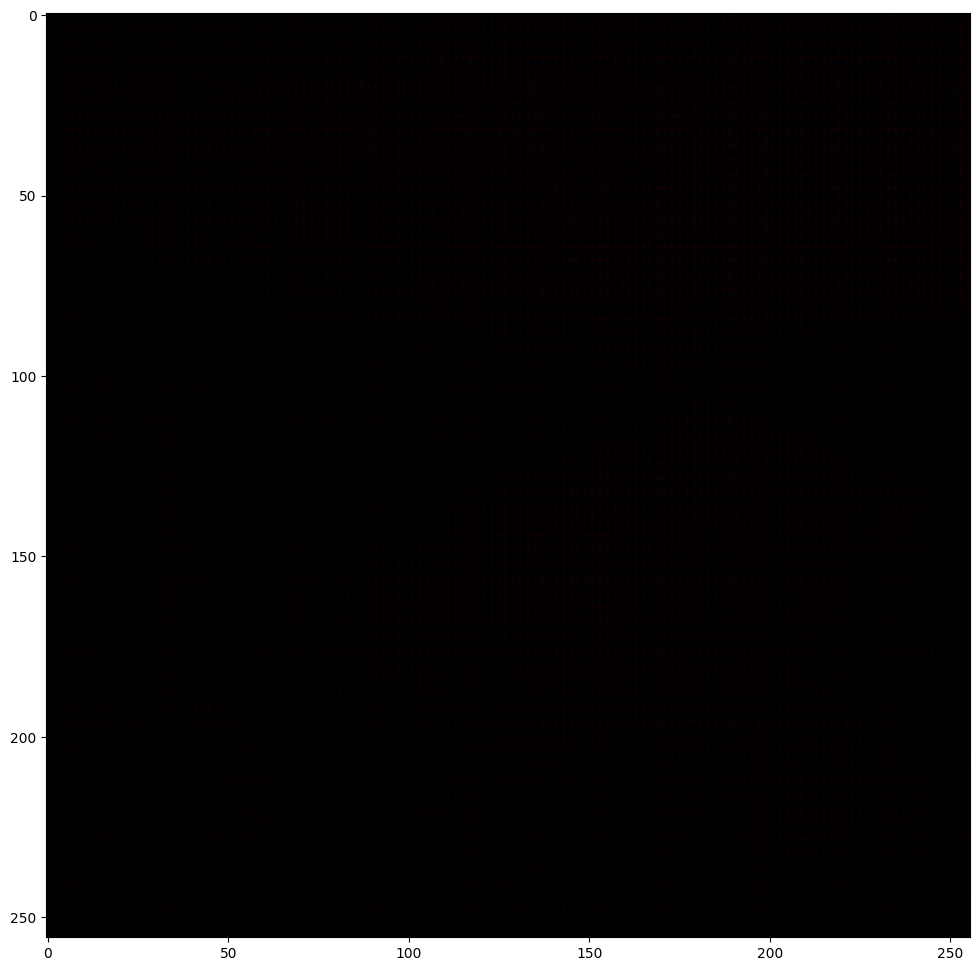

In [15]:
#example output of generator without training of generator

gen_output = generator([content_images[2],style_images[2]], training=False)
plt.imshow(gen_output[0, ...])

In [16]:
LAMBDA = 100  # this constant is used to get the weighted loss so that we can generate less blurry images 
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [17]:
# patch gan discriminator architecture

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  inp_2 = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image_2')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  a = tf.keras.layers.add([inp, inp_2]) 

  x = tf.keras.layers.concatenate([a, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp,inp_2, tar], outputs=last)

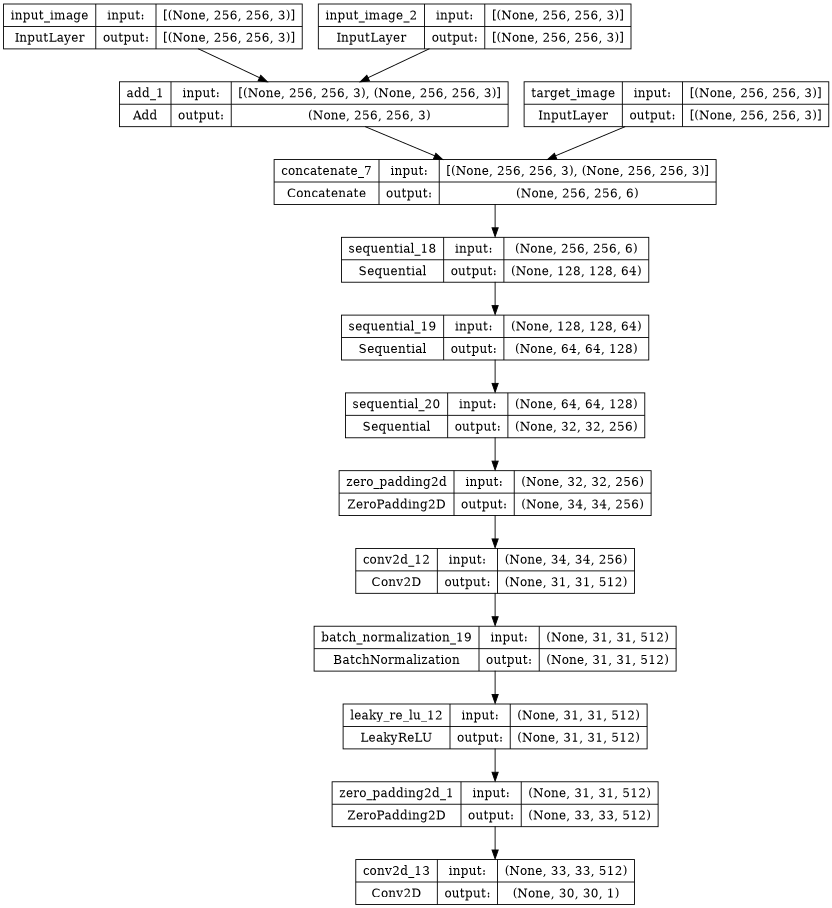

In [18]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)  # architecture of discriminator

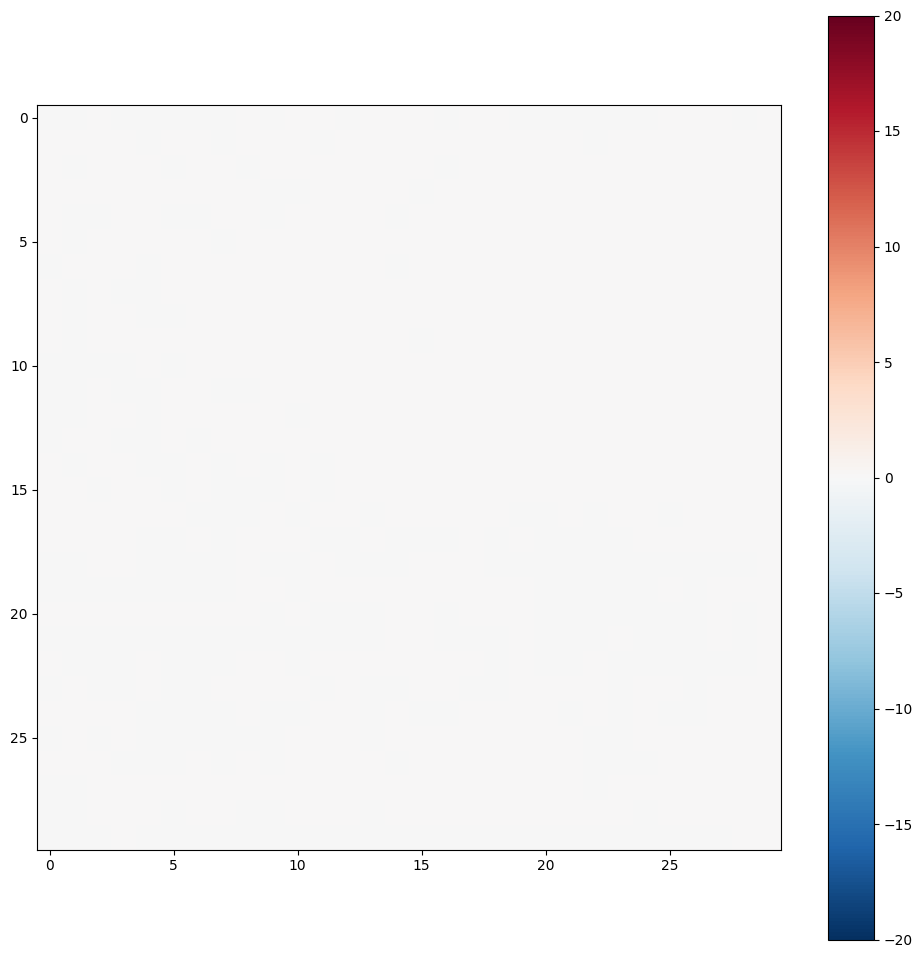

In [20]:
disc_out = discriminator([content_images[100],style_images[100], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()  # checking distibution of colours in images, since model not trained hence not much visible colour pixels are there

In [21]:
# discriminator loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [22]:
#optimizers for both generator and discriminator and checkpoint restoring directory so that we can resume training from
#last saved model, if any case some technical isseue arrises

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = '/kaggle/working/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
# function to generate the images for visualization 

def generate_images(model, content_input,style_input, tar):
  prediction = model([content_input,style_input], training=True)
  plt.figure(figsize=(15, 15))

  display_list = [content_input[0],style_input[0], tar[0], prediction[0]]
  title = ['content Image','style image' ,'Ground Truth', 'Predicted Image']

  for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

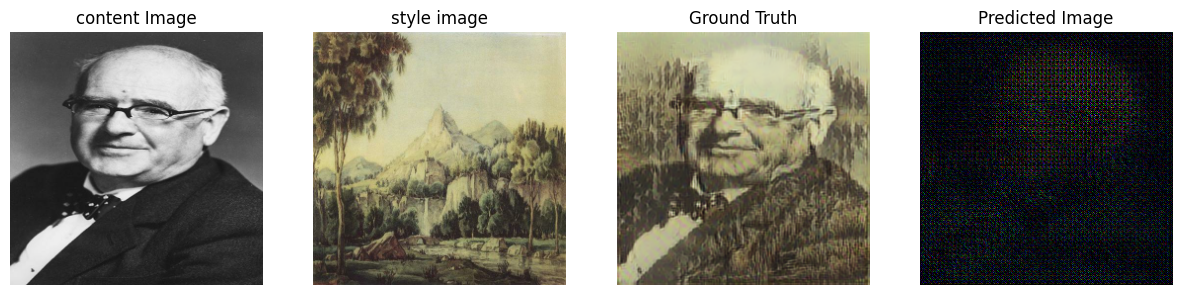

In [24]:
#example of non trained generator model

generate_images(generator, content_images[60],style_images[60], labels[60])

In [26]:
# saving logs of model
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [27]:
# to train th generator model and minimizing the loss 


def train_step(content_image, style_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator([content_image,style_image], training=True)

    disc_real_output = discriminator([content_image,style_image, target], training=True)
    disc_generated_output = discriminator([content_image,style_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, # optimizes the generator loss
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,  # optimizes the discriminator loss
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [28]:
# here is the final training step for 50 epochs


from tqdm import tqdm
def fit(steps):
    
    example_content_input,example_style_input, example_target = content_images[596],style_images[596],labels[596] #this image is not present in training images
    start = time.time()
    
    for j in range(50):
    
        for i in range(len(labels)-5): #kept last five images for testing
            if i%300 == 0:
                print('reached ',i)
                
                
            content_input,style_input,target = content_images[i],style_images[i],labels[i]
            
            train_step(content_image,style_image, target, steps)
       

        if  j%10 == 0:
            print(f'Time taken for {j} epoch: {time.time()-start:.2f} sec\n')
            generate_images(generator, example_content_input,example_style_input, example_target)

        start = time.time()

        
     

        

  
    

reached  0
reached  300
Time taken for 0 epoch: 131.07 sec



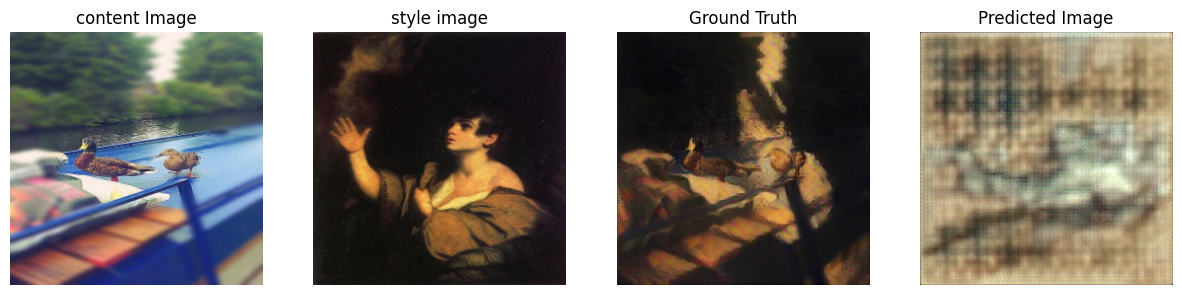

reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
Time taken for 10 epoch: 123.64 sec



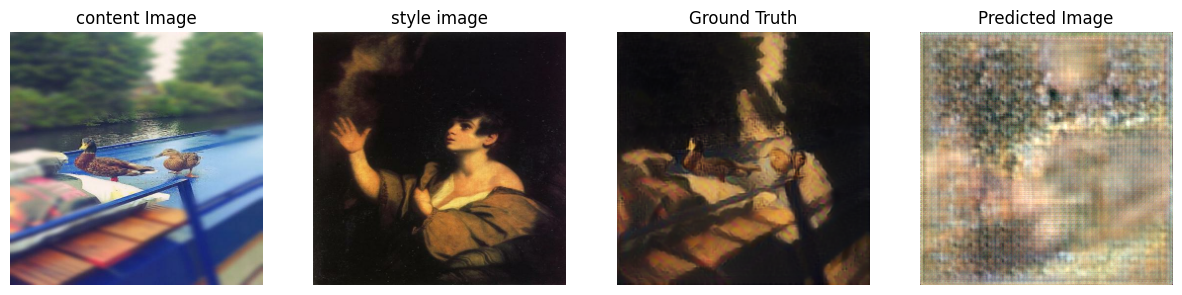

reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
Time taken for 20 epoch: 124.60 sec



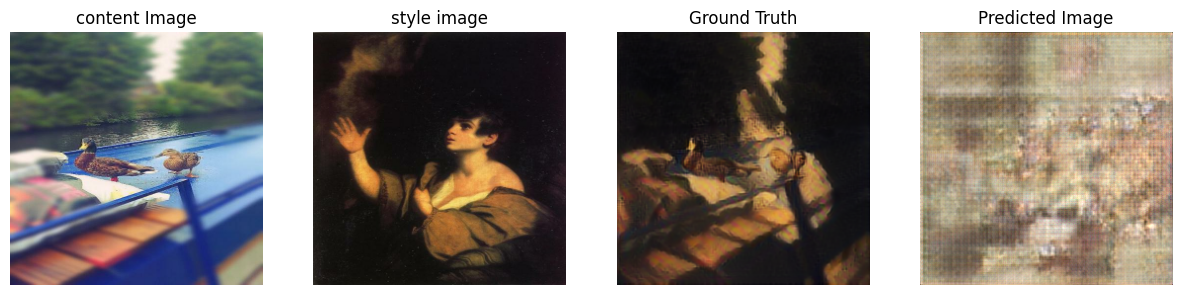

reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
Time taken for 30 epoch: 126.40 sec



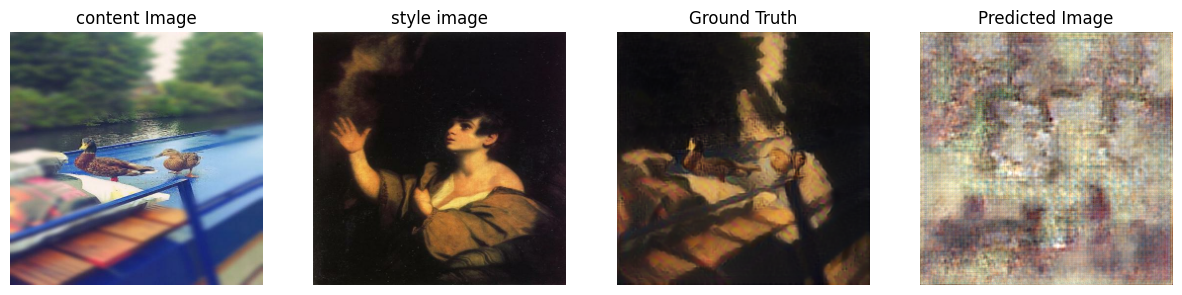

reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
reached  0
reached  300
Time taken for 40 epoch: 123.76 sec



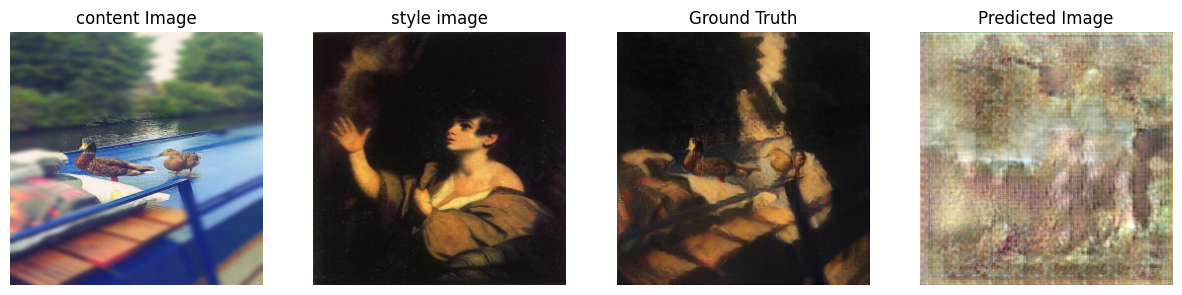

reached  0


KeyboardInterrupt: 

In [29]:
fit(steps=500)  # it was taking a longer time to get train so i stopped it between after 40 epochs

# examples of CNN based model 

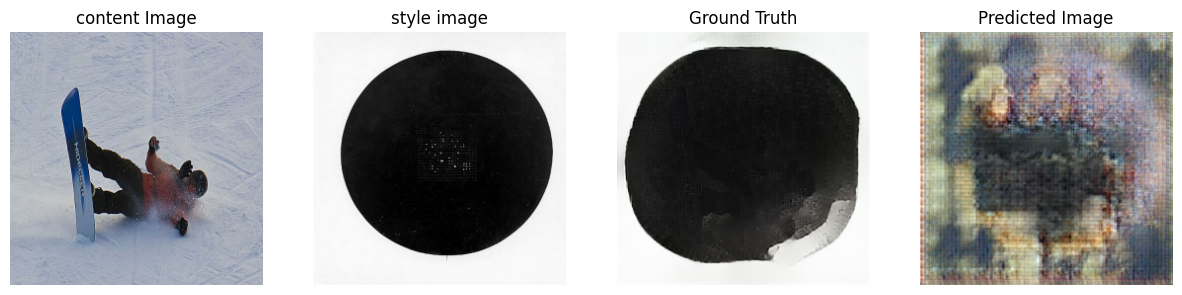

In [30]:
generate_images(generator, content_images[597],style_images[597], labels[597])

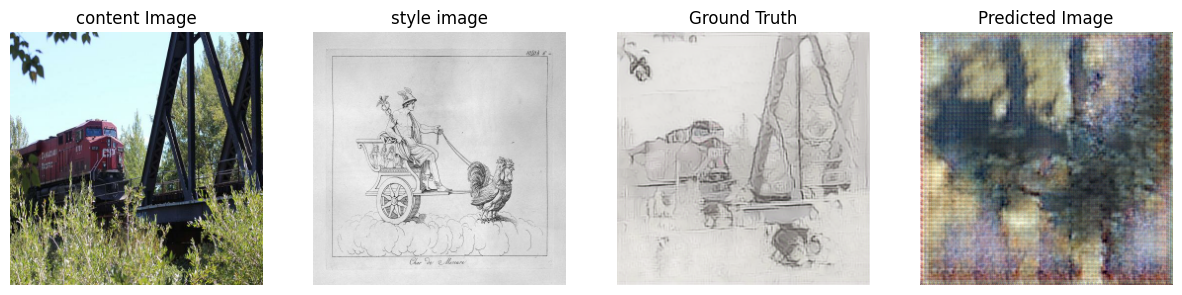

In [31]:
n = 598
generate_images(generator, content_images[n],style_images[n], labels[n])

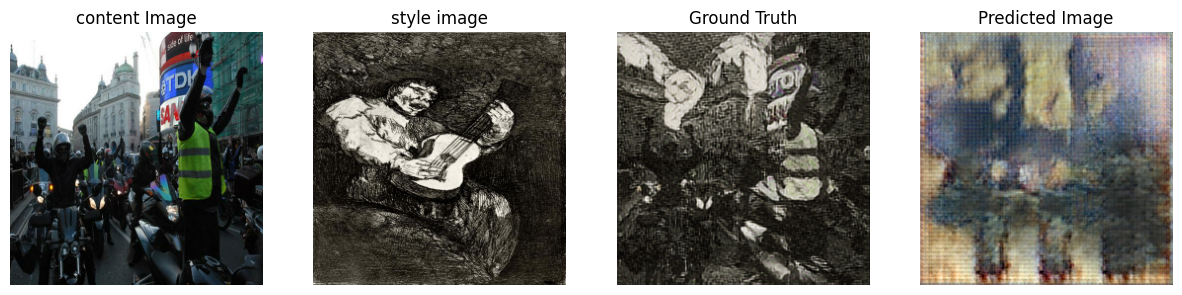

In [32]:
n = 599
generate_images(generator, content_images[n],style_images[n], labels[n])

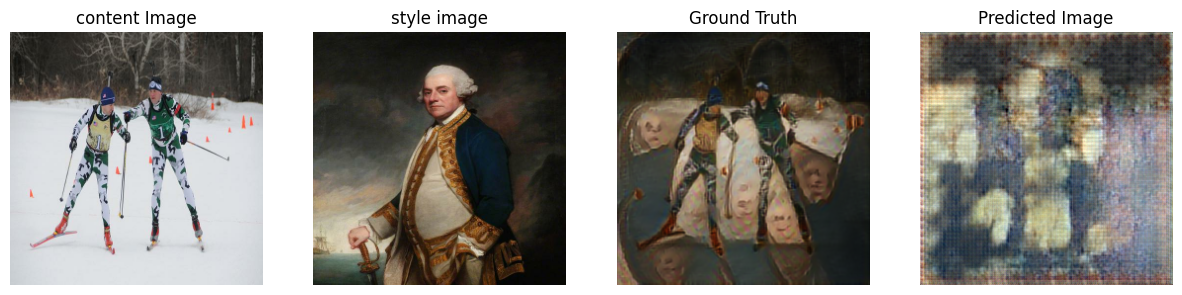

In [33]:
n = 595
generate_images(generator, content_images[n],style_images[n], labels[n])

## reason for these type of results 

results are not good but i belive we can  get  best results for some particular tasks, since in this problem our dataset was too distributed, due to which it could not capture any similarity in the styled images.